In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import xarray as xr
import random 
import os 
import pandas as pd 
from global_land_mask import globe
import joblib

from work import handler
from work import casestudy
from work import storm_tracker
from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.16 seconds


In [52]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)

ds = ds.drop_isel(DCS_number = [250, 266, 267, 284, 285, 286, 307]) # see data_miniz_viz.ipynb, auto_encoder_v3
filename_save = f"rcond_sigma_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
storms = xr.open_dataset(storms_path)
storms_aligned = storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation

all_storms = xr.open_dataset(st.file_storms)
all_storms_aligned = all_storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation
ds = xr.merge([ds, storms_aligned, all_storms_aligned])

def is_both_ocean(lat1, lon1, lat2, lon2):
    return not globe.is_land(lat1, lon1) and not globe.is_land(lat2, lon2)

mask = xr.apply_ufunc(is_both_ocean,ds["lat_init"],ds["lon_init"],ds["lat_max_instant"],ds["lon_max_instant"], vectorize=True)
ds = ds.where(mask, drop=True)

ds

<xarray.Dataset>
Dimensions:                   (DCS_number: 375, z: 52, time: 911)
Coordinates:
  * DCS_number                (DCS_number) int64 153524 153529 ... 295399 297410
  * z                         (z) float32 20.0 61.2 ... 1.447e+04 1.497e+04
  * time                      (time) int64 817681 817682 ... 818590 818591
Data variables: (12/79)
    TABS_init_profile         (DCS_number, z) float64 300.9 300.4 ... 206.8
    QV_init_profile           (DCS_number, z) float64 20.67 19.75 ... 0.002887
    U_init_profile            (DCS_number, z) float64 7.383 8.902 ... 6.671
    V_init_profile            (DCS_number, z) float64 2.693 2.968 ... 0.594
    TABS_max_instant_profile  (DCS_number, z) float64 301.1 300.6 ... 206.2
    QV_max_instant_profile    (DCS_number, z) float64 21.04 20.0 ... 0.003031
    ...                        ...
    LC_tbavg_208K             (DCS_number, time) float64 nan nan nan ... 0.0 0.0
    LC_tbavg_241K             (DCS_number, time) float64 nan nan ... 229.3 229.9
    LC_tbmin                  (DCS_number, time) float64 nan nan ... 220.0 222.0
    LC_x                      (DCS_number, time) float64 nan nan ... 5.1e+03
    LC_y                      (DCS_number, time) float64 nan nan ... 1.744e+03
    QCgeo_IRimage             (DCS_number, time) float64 nan nan nan ... 1.0 1.0

In [ ]:
X_prec = np.stack([
    ds["INT_rcond_1mmh"].values,
    ds["INT_rcond_10mmh"].values,
    ds["INT_rcond_30mmh"].values,
    ds["INT_sigma_1mmh"].values,
    ds["INT_sigma_10mmh"].values,
    ds["INT_sigma_30mmh"].values
    ], axis=1)

X_morpho = np.stack([
    ds["INT_TbMin"].values, 
    ds["INT_surfmaxkm2_241K"].values, 
    ds["INT_velocityAvg"].values,
    ds["INT_duration"].values,
    # ds["INT_"]
], axis=1)

# from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.ml_tools.standard_scaler_from_ds import scale_profiles_v2

X, X_scaled, scaler_profiles = scale_profiles_v2(ds)

from tensorflow import keras
latent_space_size = 36
model_name = 'ae_fully_connected_v3'+f"_latent_{latent_space_size}"
ae_name = f'{model_name}_v0.keras'

save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)

# Load the autoencoder
autoencoder = keras.models.load_model(save_path_ae)

# Using the name of the bottleneck layer
encoder_output = autoencoder.get_layer('dense_30').output  # Replace 'bottleneck' with actual name

# Reconstruct the encoder model
encoder = keras.Model(inputs=autoencoder.input, outputs=encoder_output)
print("Autoencoder input shape:", autoencoder.input_shape)
print("X_scaled shape:", X_scaled.shape)

# Encode the data
X_latent_full = encoder.predict(X_scaled)
X_latent = X_latent_full[:, ~(np.sum(X_latent_full, axis=0)==0)]
print("Latent representation shape:", X_latent.shape)

X_clustering = np.hstack([X_latent, X_prec, X_morpho]) 
X_clustering = X_clustering[~np.isnan(X_clustering).any(axis=1)]

Autoencoder input shape: (None, 46, 12)
X_scaled shape: (375, 46, 12)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Latent representation shape: (375, 24)


In [54]:
# load UMAP embeddings and cluster labels as numpy arrays
X_umap_name = "X_umap_v1.npy"
X_umap_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, X_umap_name) 
X_umap = np.load(X_umap_savepath)

clusters_name = "hdbscan_labels_v0_of_X_umap_v1.npy"
clusters_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, clusters_name)
Y_clustering = np.load(clusters_savepath)

path_scaler_save = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, 'scaler_profiles.joblib')
scaler_profiles = joblib.load(path_scaler_save)

In [55]:
# Latent space variables (first 24 variables)
latent_var_names = [f'Latent{i+1}' for i in range(24)]

# Remaining 10 variables as provided
other_var_names = [
    "INT_rcond_1mmh",
    "INT_rcond_10mmh",
    "INT_rcond_30mmh",
    "INT_sigma_1mmh",
    "INT_sigma_10mmh",
    "INT_sigma_30mmh",
    "INT_TbMin", 
    "INT_surfmaxkm2_241K", 
    "INT_velocityAvg",
    "INT_duration",
]

# Combine all variable names into a single list
variable_names = latent_var_names + other_var_names

classes = np.unique(Y_clustering)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


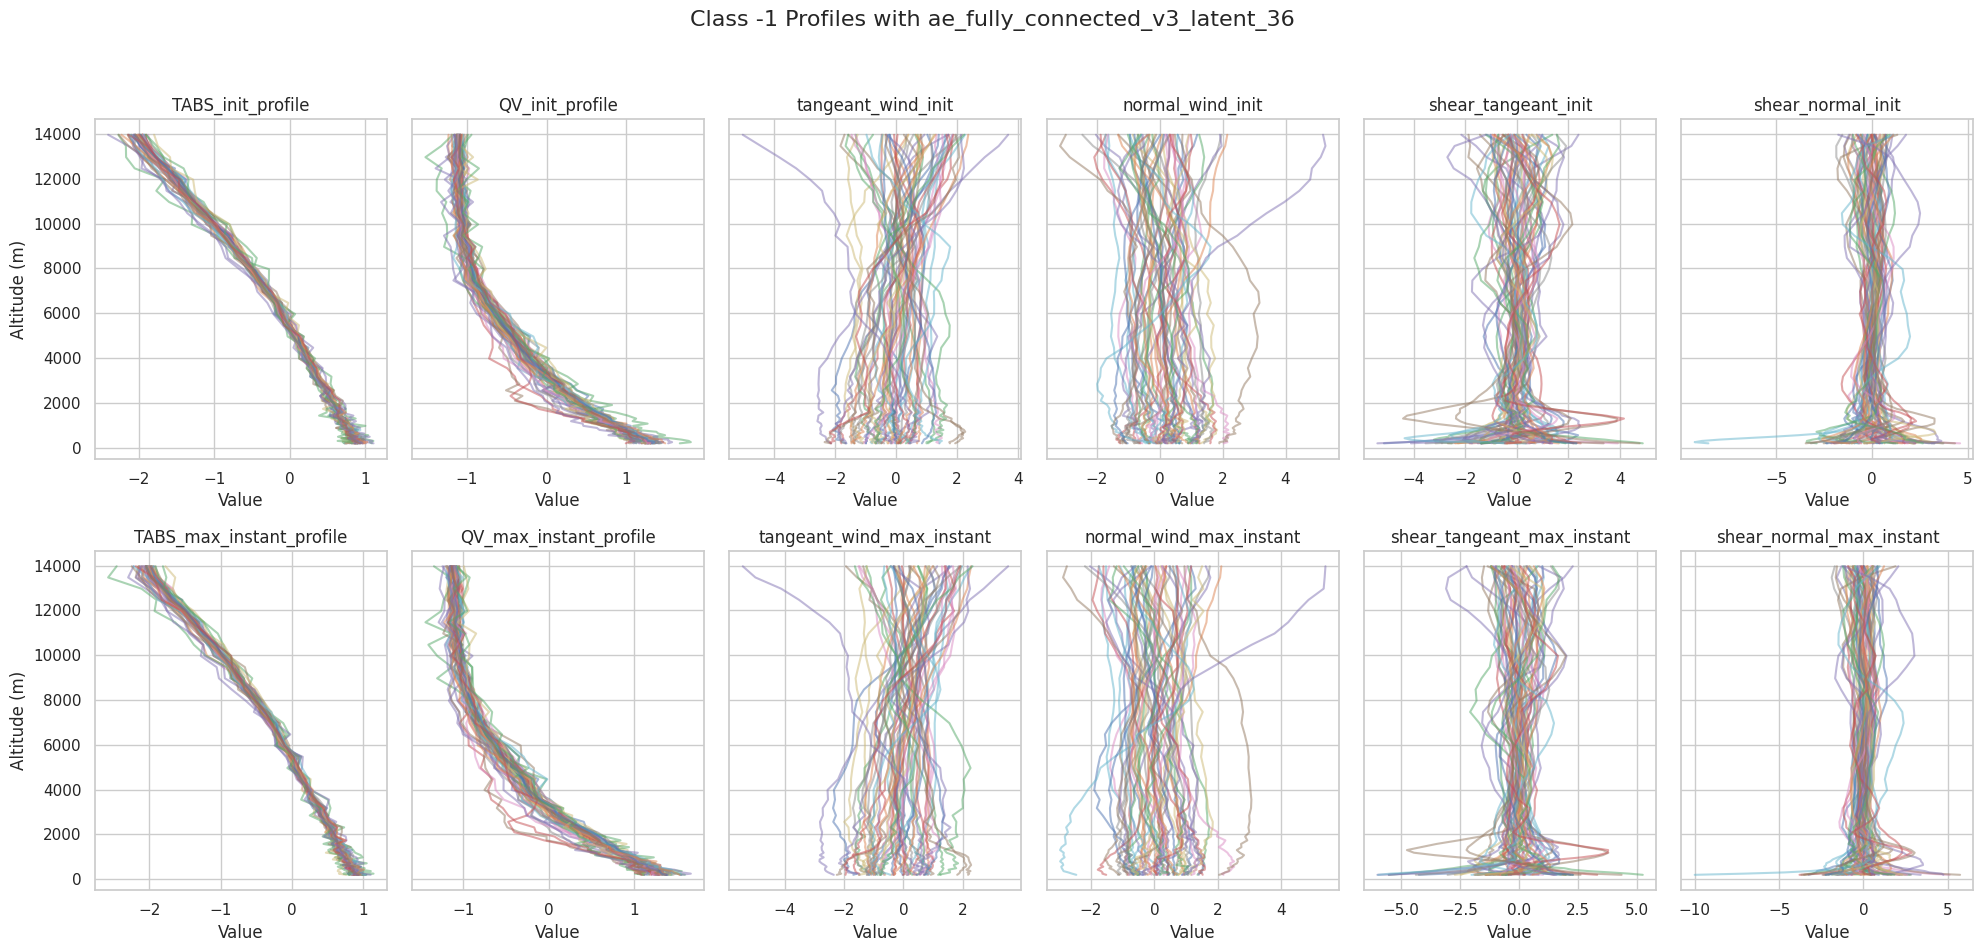

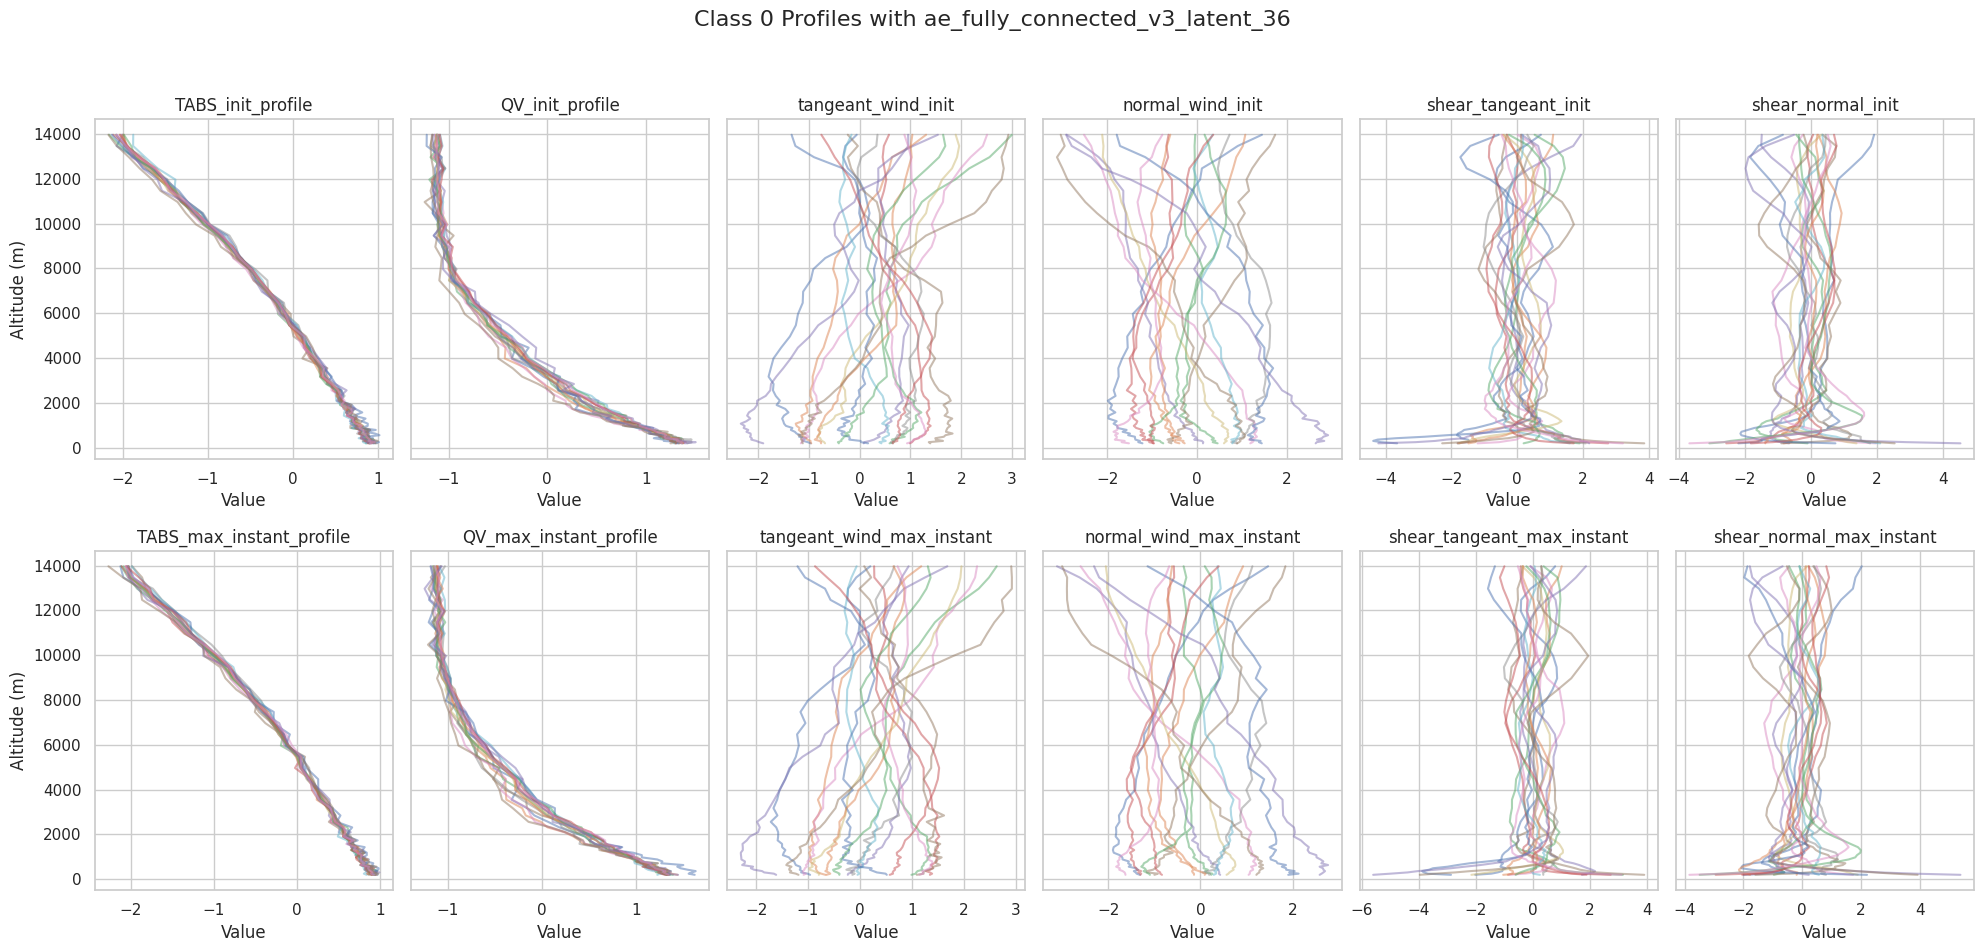

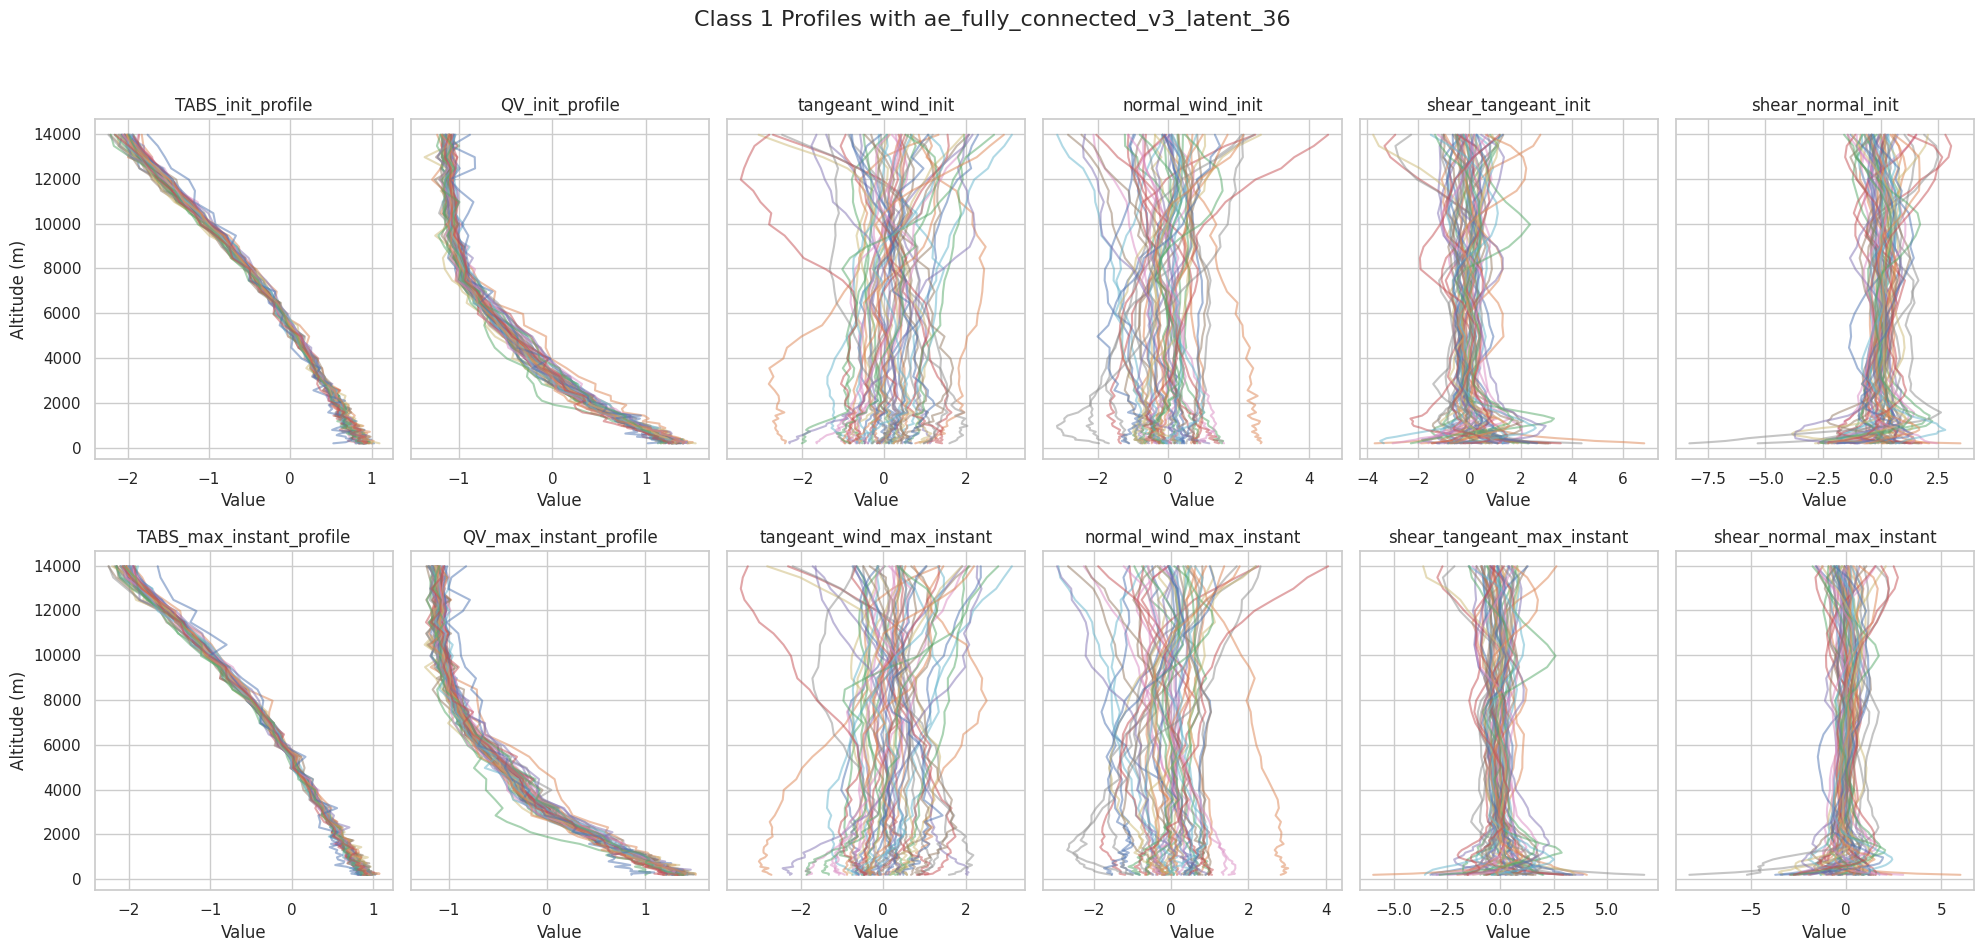

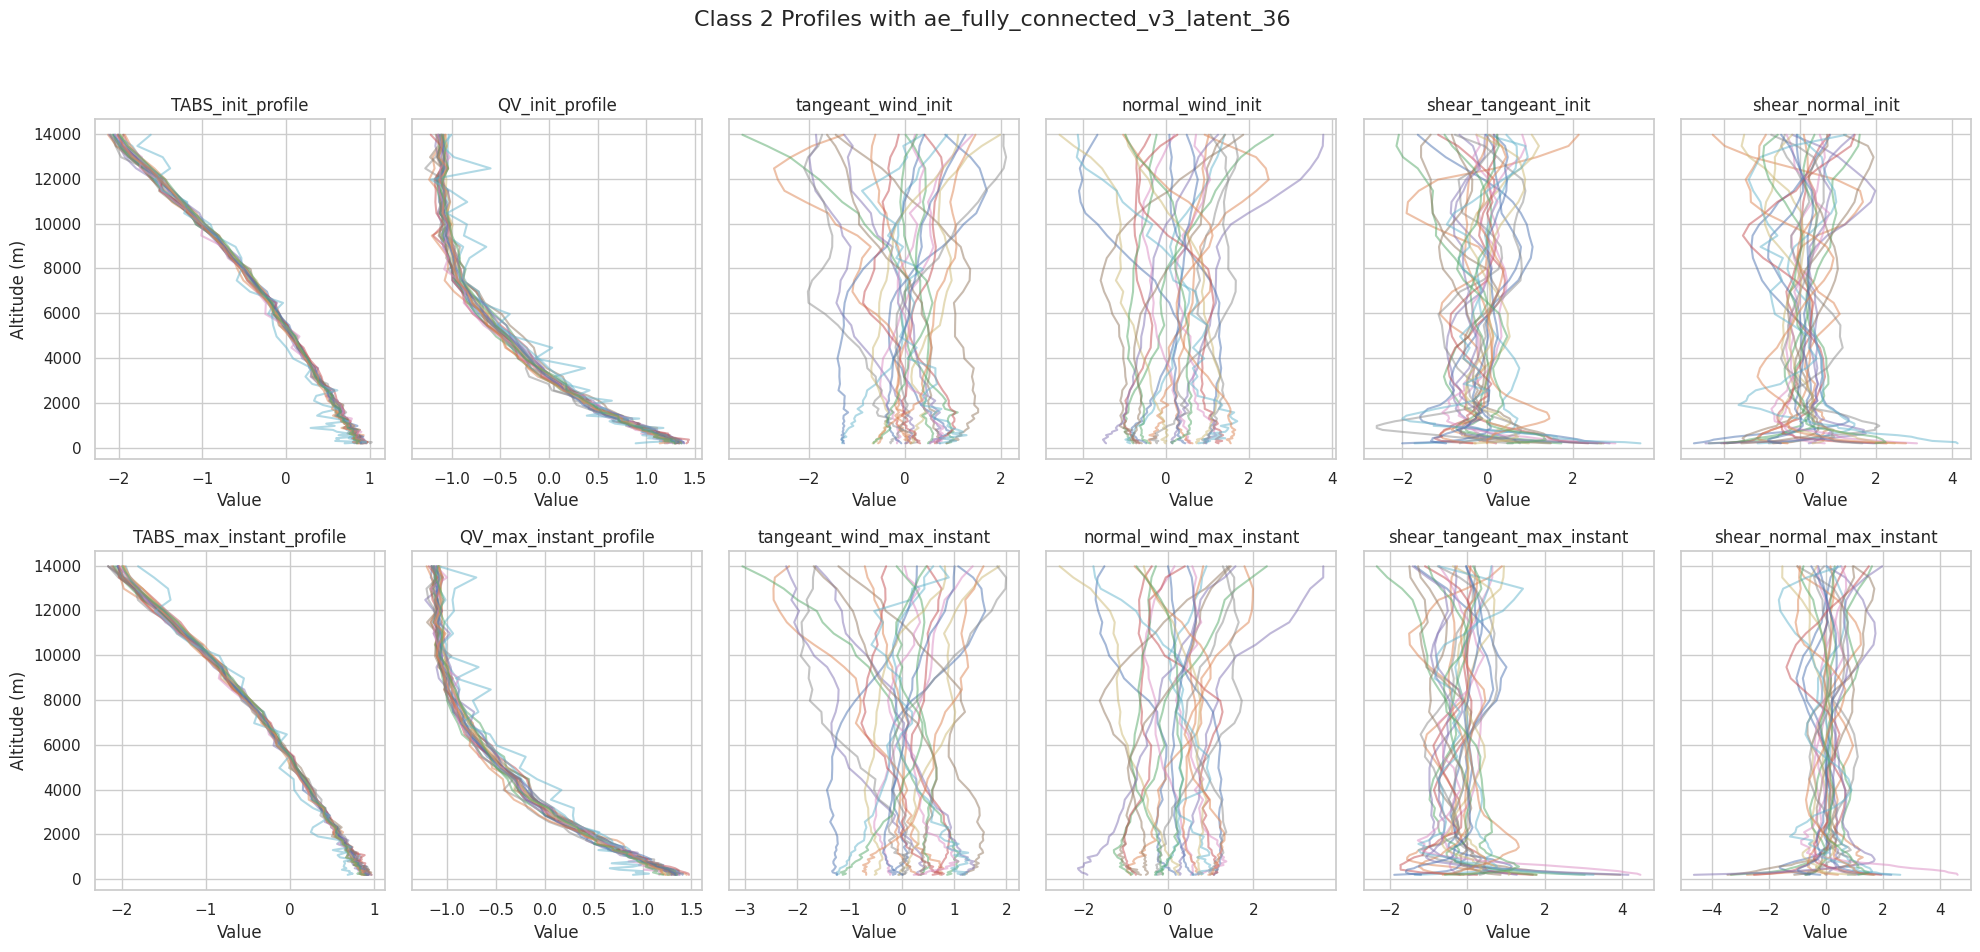

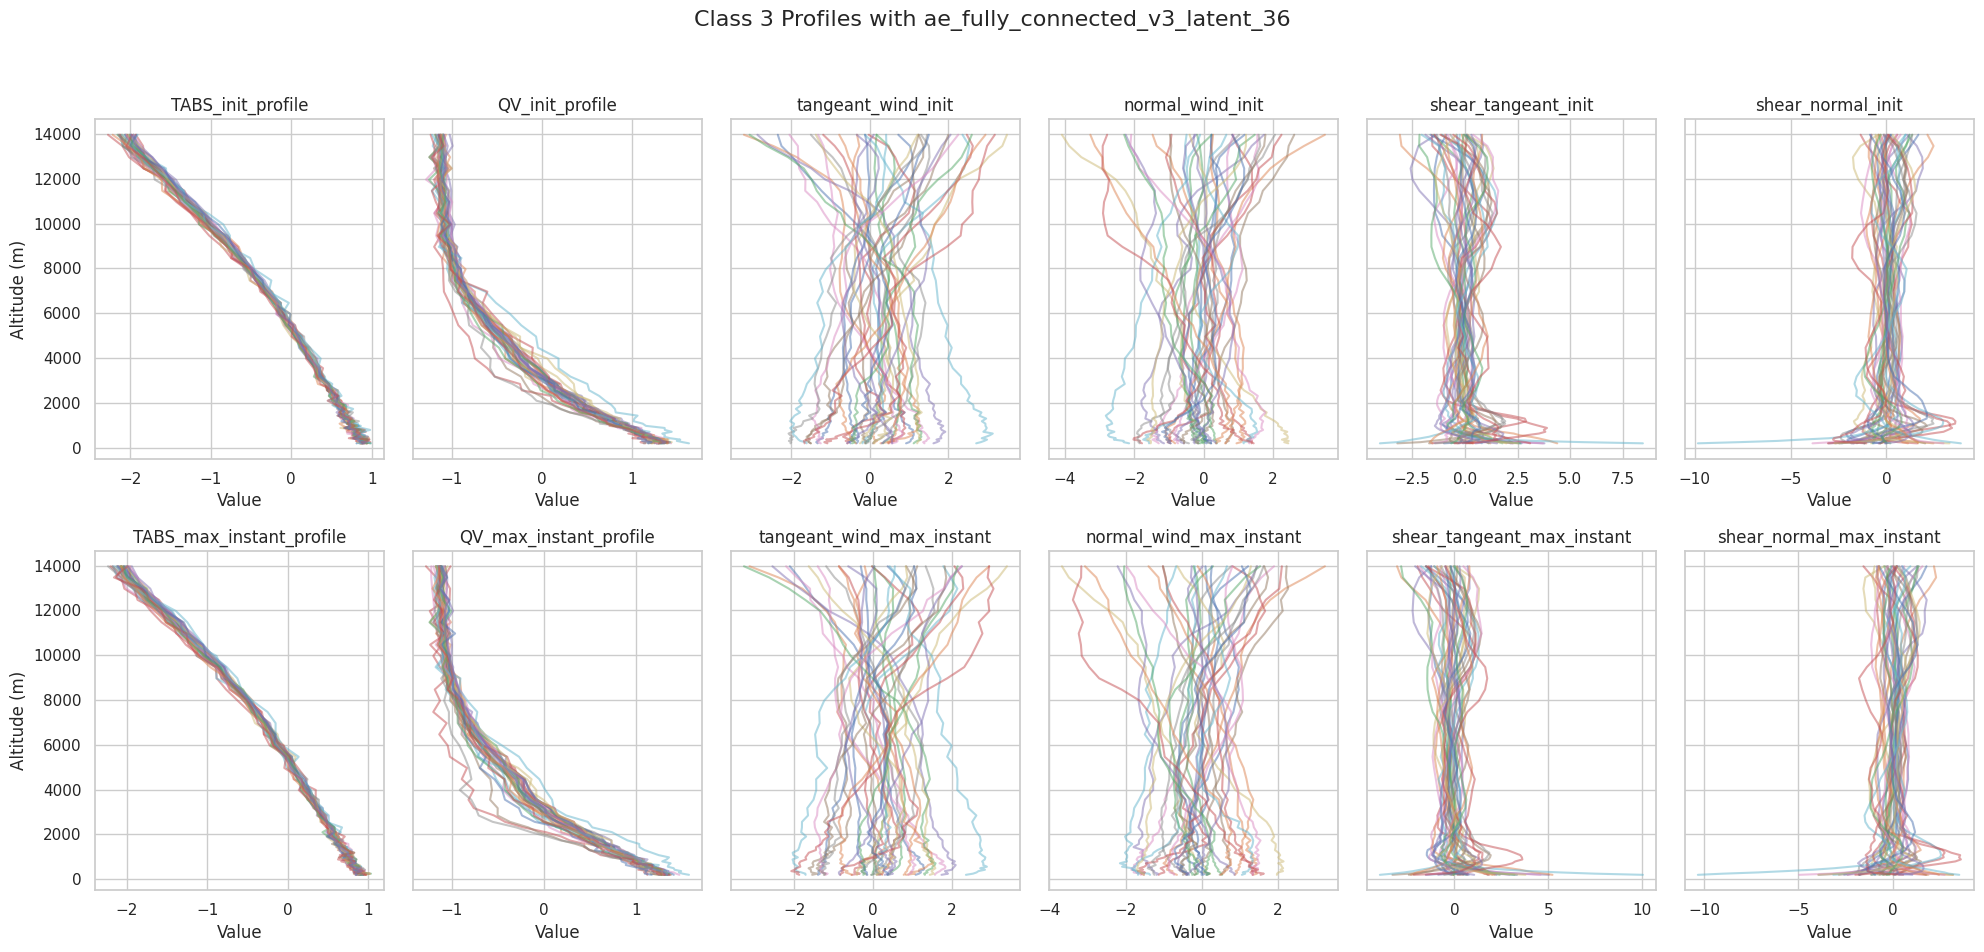

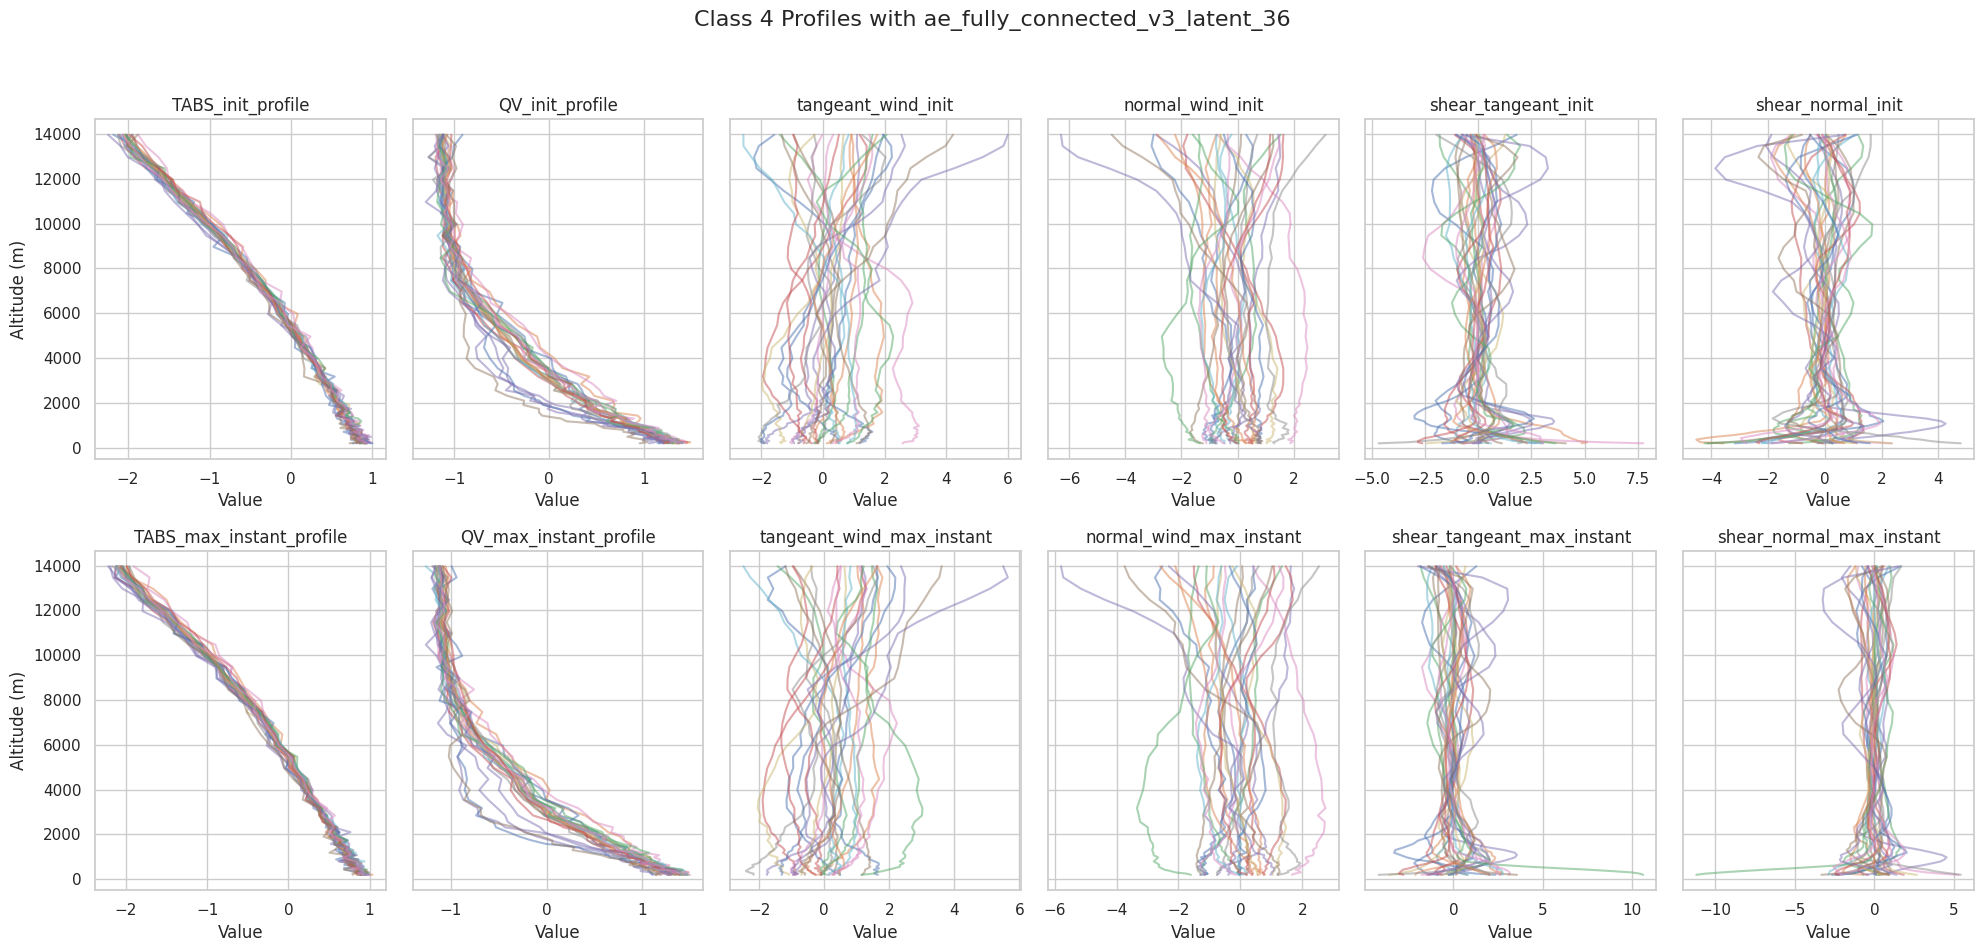

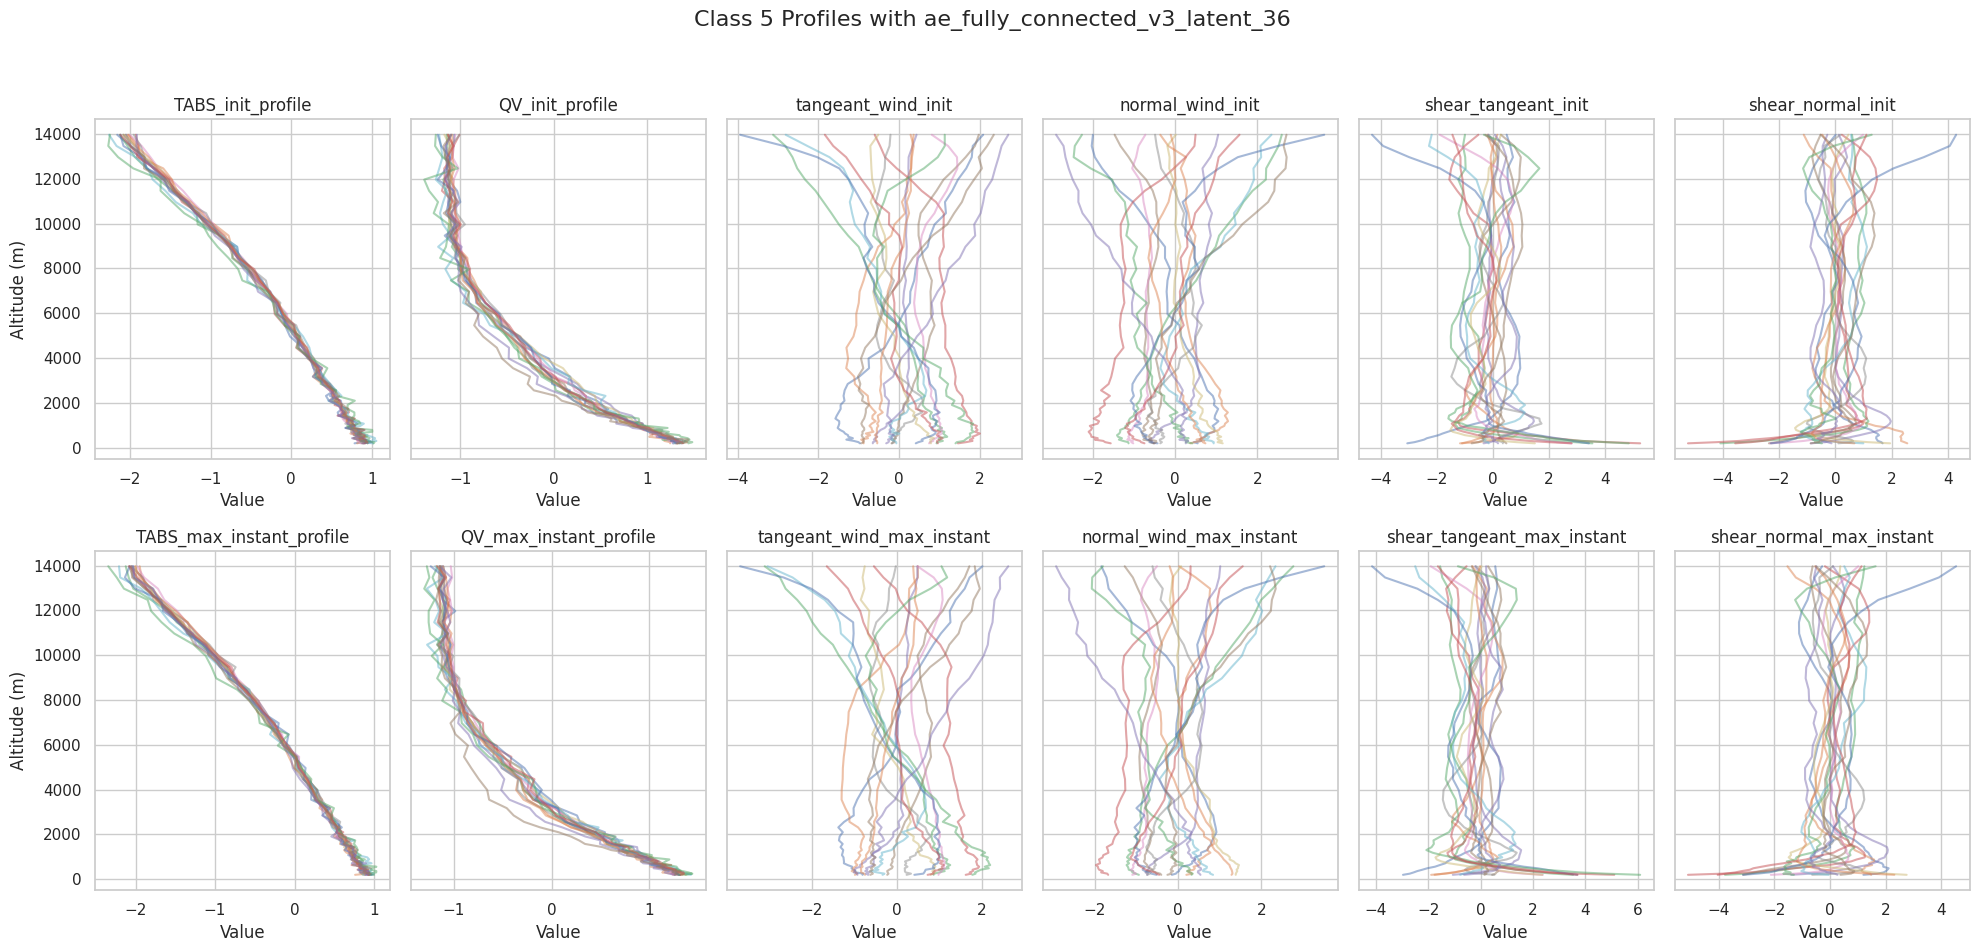

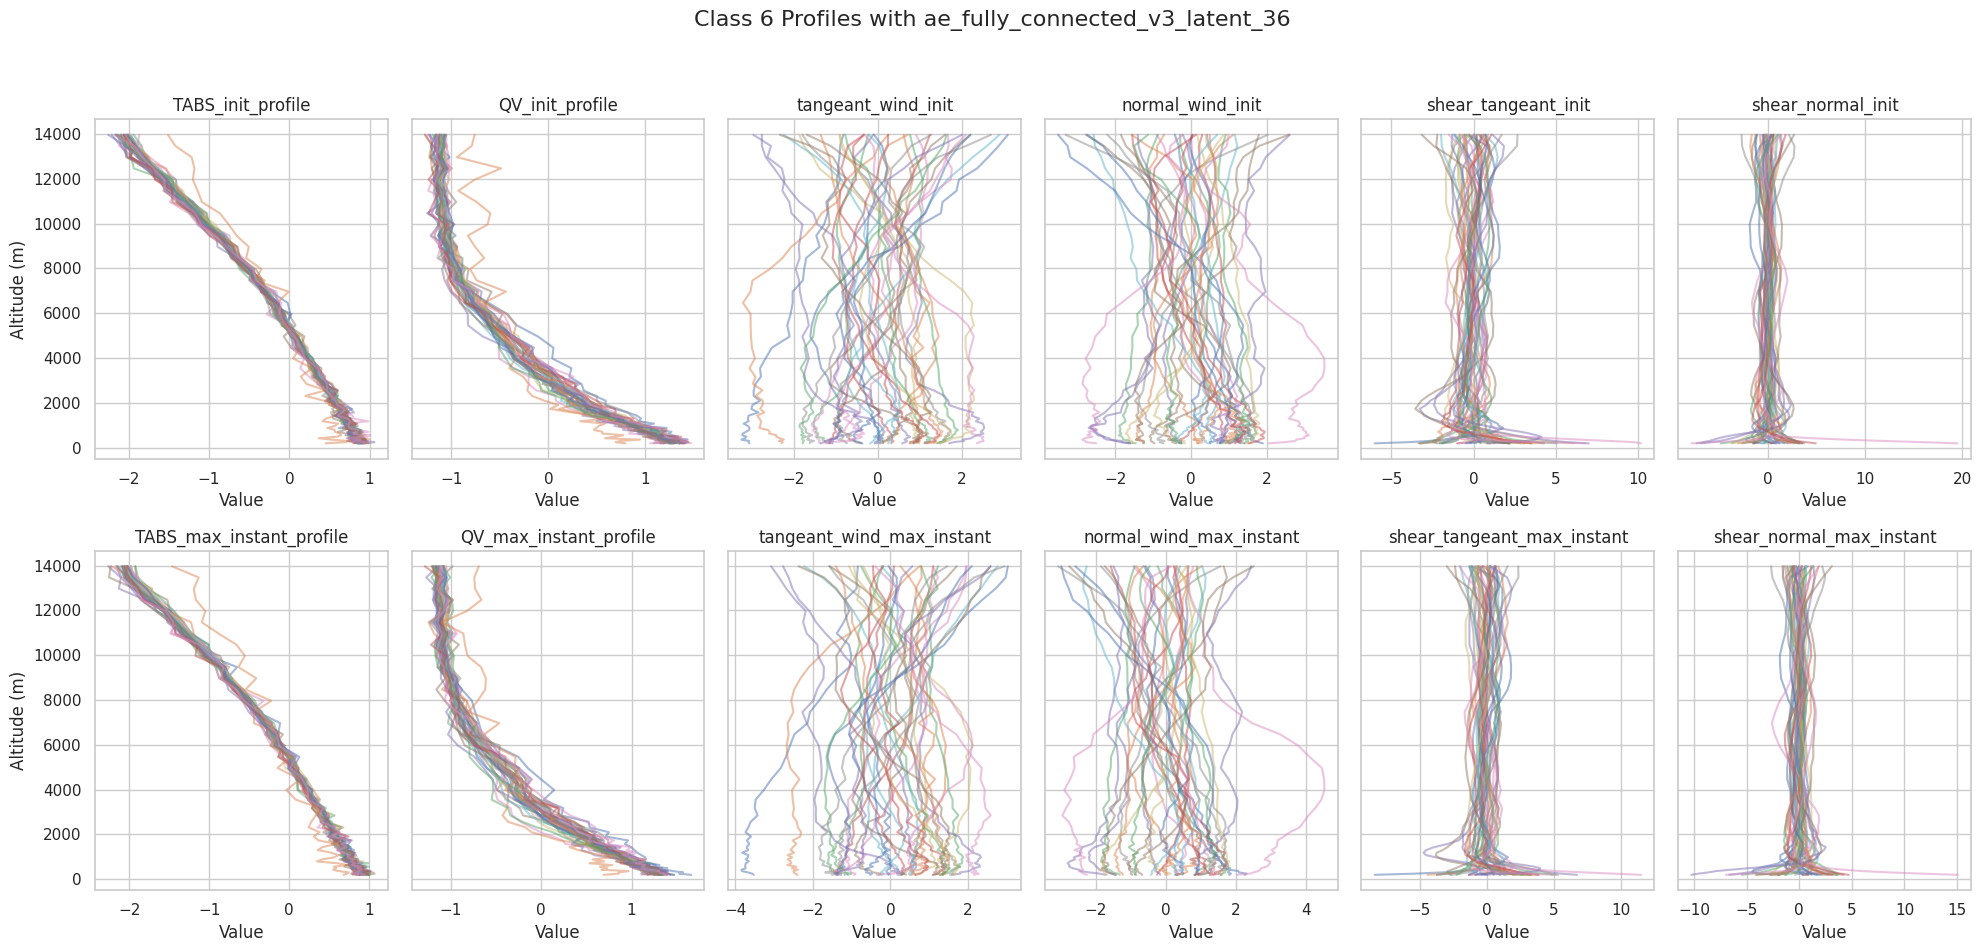

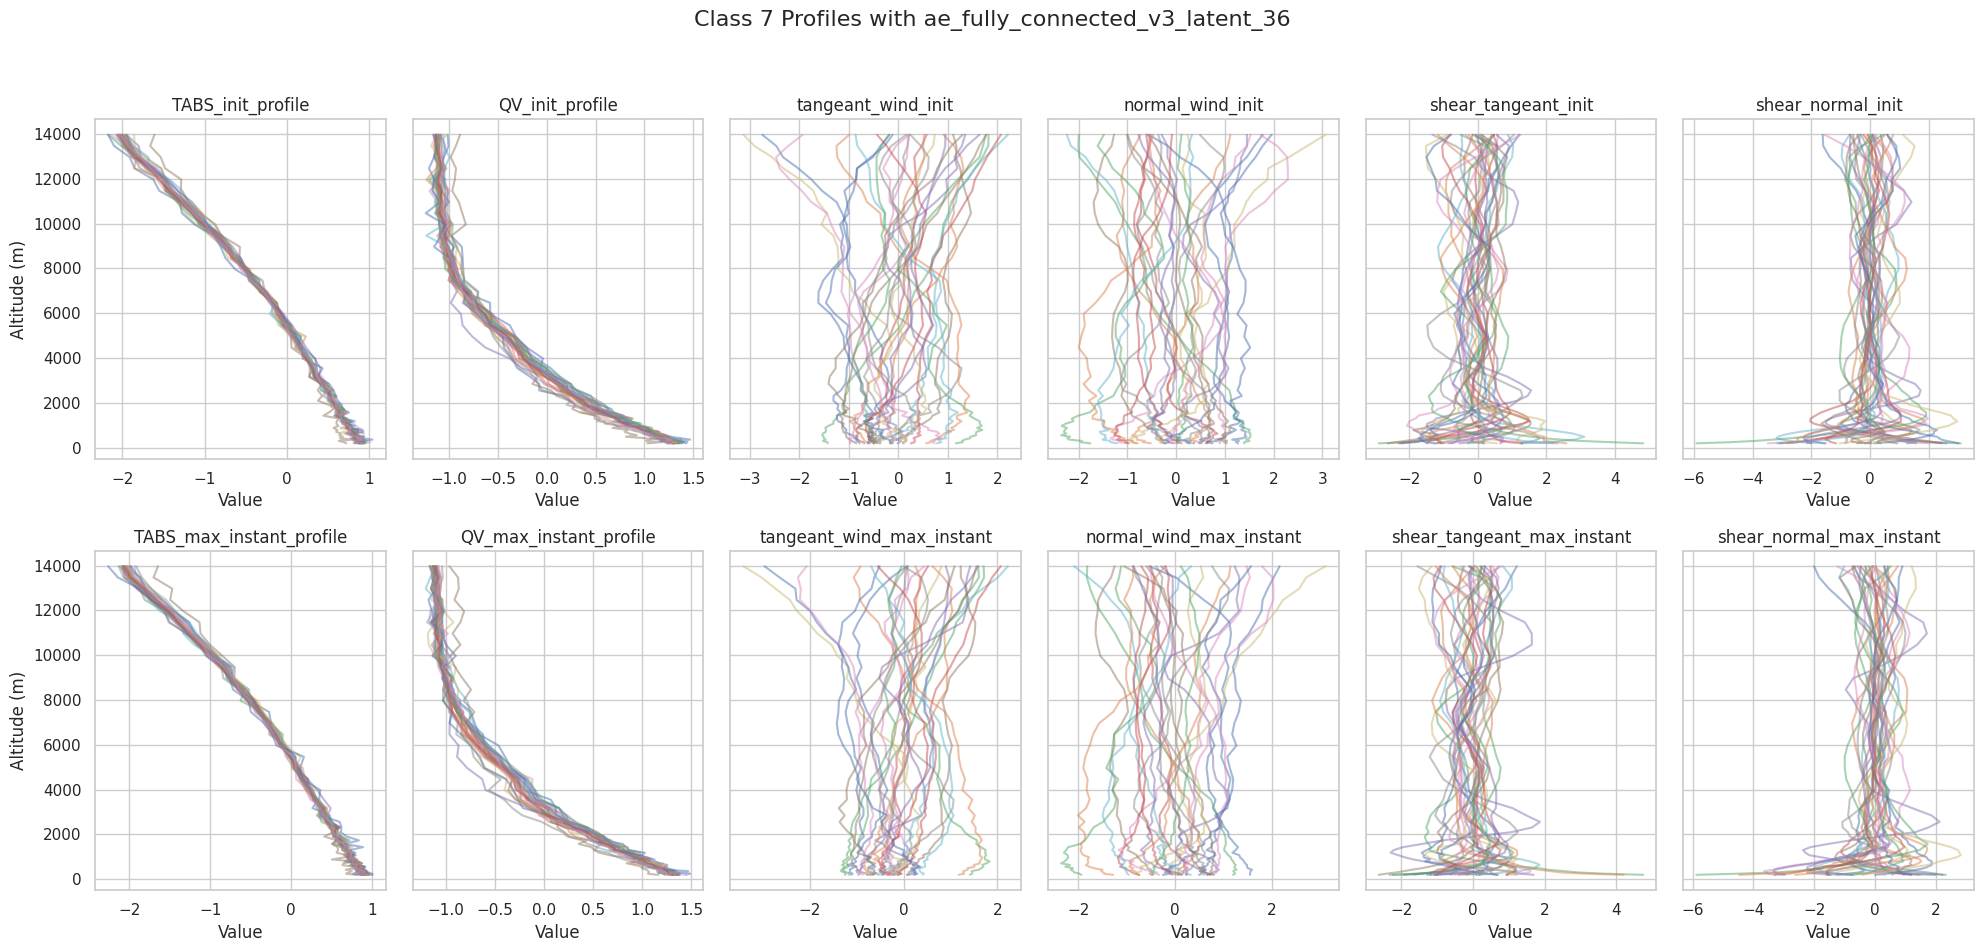

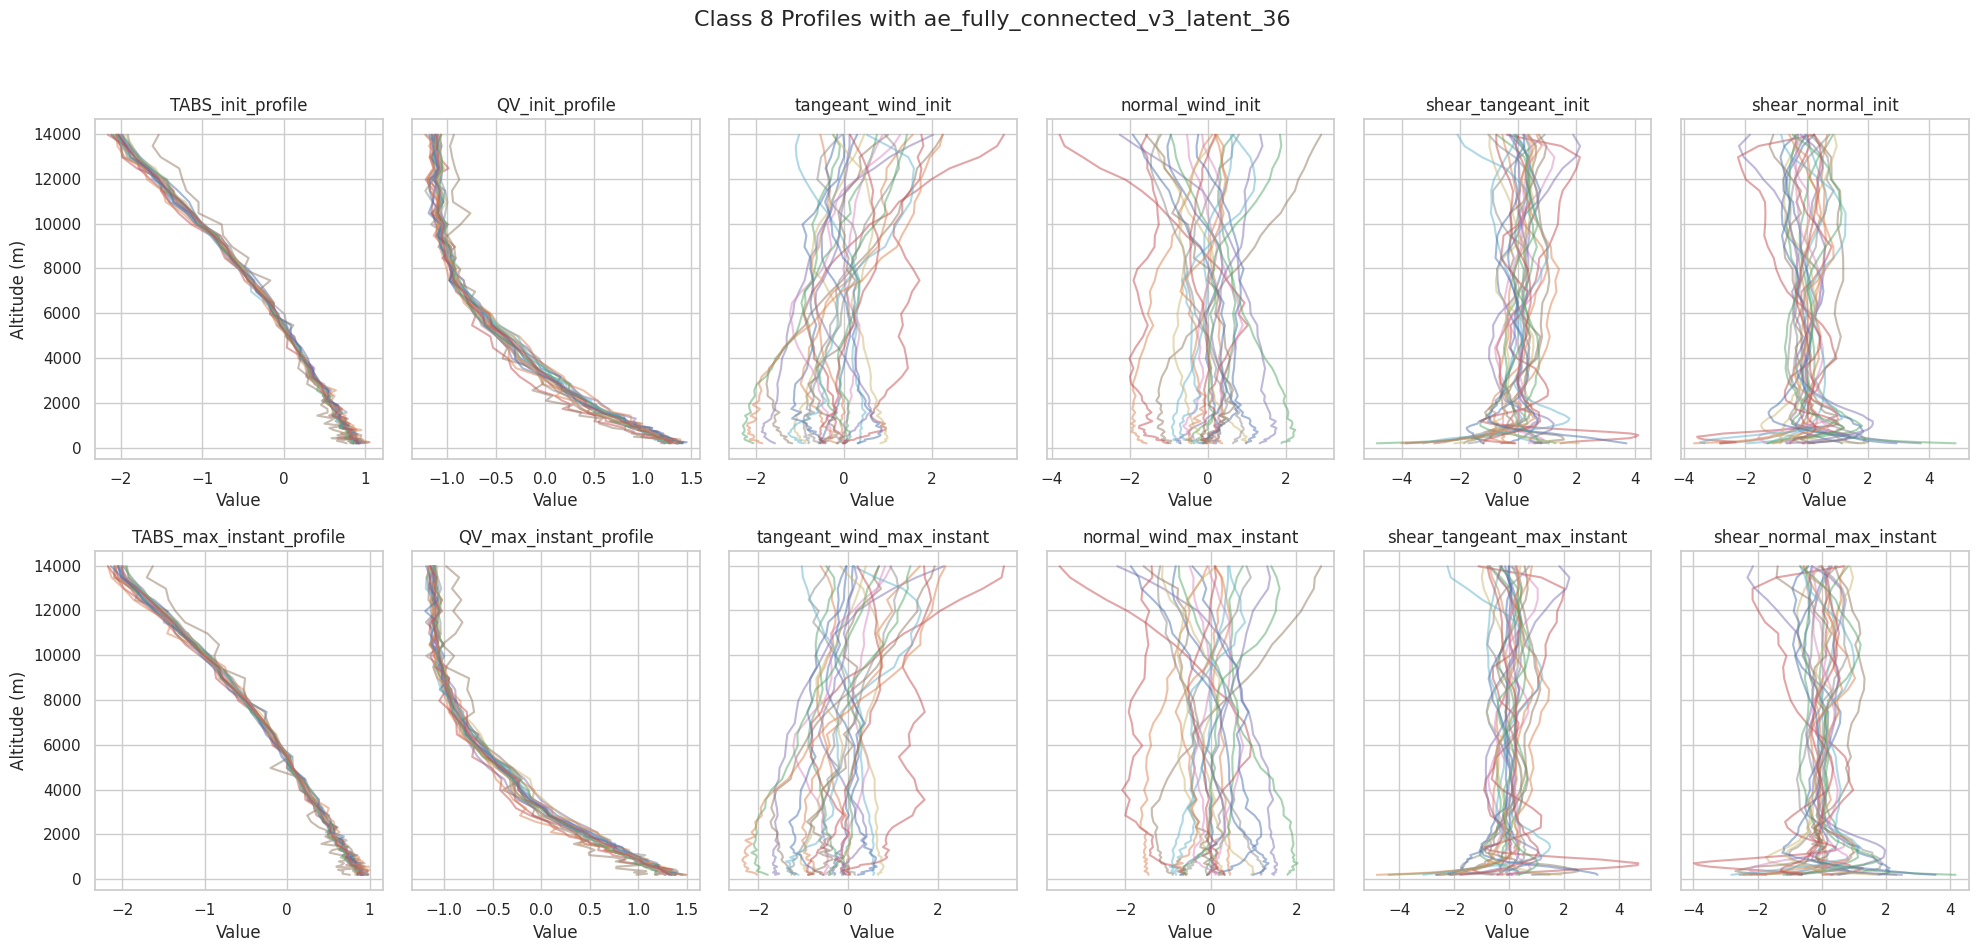

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

variables = [
    'TABS_init_profile', 'QV_init_profile', 'tangeant_wind_init', 'normal_wind_init', 'shear_tangeant_init', 'shear_normal_init', #'shear_magnitude_init', #'shear_magnitude_init_bis',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'tangeant_wind_max_instant', 'normal_wind_max_instant', 'shear_tangeant_max_instant', 'shear_normal_max_instant', #'shear_magnitude_max', #'shear_magnitude_max_bis'
]

z_levels = ds['z'].values[4:-2]  # Vertical levels


# Step 1: Reconstruct the profiles from the latent space vector X_latent_full

# Find the index of the bottleneck layer
bottleneck_layer_name = 'dense_30'  # Replace with your actual bottleneck layer name
for i, layer in enumerate(autoencoder.layers):
    if layer.name == bottleneck_layer_name:
        bottleneck_layer_index = i
        break

# Get the decoder layers
decoder_layers = autoencoder.layers[bottleneck_layer_index+1:]

# Build the decoder model
latent_space_size = 36
decoder_input = keras.Input(shape=(latent_space_size,))
x = decoder_input
for layer in decoder_layers:
    x = layer(x)
decoder_output = x
decoder = keras.Model(inputs=decoder_input, outputs=decoder_output)

# Reconstruct the data
reconstructed_data = decoder.predict(X_latent_full)
# reconstructed_data = scaler_profiles.inverse_transform(reconstructed_data)

# Step 2: Plot the reconstructed profiles for each class

def plot_class_profiles(class_index, reconstructed_data, variables, z_levels, Y_clustering, model_name="Model"):
    # Get indices of samples belonging to the class
    indices = np.where(Y_clustering == class_index)[0]
    reconstructed_samples = reconstructed_data[indices]  # Shape: (num_samples_in_class, num_levels, num_features)
    
    # For each variable, plot the profiles
    n_cols = 6
    n_rows = int(np.ceil(len(variables)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
    fig.suptitle(f'Class {class_index} Profiles with {model_name}', fontsize=16)
    
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        for sample in reconstructed_samples:
            profile = sample[:, i]
            ax.plot(profile, z_levels, alpha=0.5)  # Adjust alpha for transparency
        ax.set_title(var)
        ax.set_xlabel('Value')
        if i % n_cols == 0:
            ax.set_ylabel('Altitude (m)')
        ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
    # Hide any unused subplots
    for j in range(len(variables), n_rows * n_cols):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Assuming you have variables, z_levels, and model_name defined
# Example:
# variables = ['Temperature', 'Humidity', 'Pressure', ...]  # List of variable names
# z_levels = np.arange(0, 10000, 1000)  # Altitude levels
# model_name = 'Autoencoder Model'

classes = np.unique(Y_clustering)
for cls in classes:
    plot_class_profiles(cls, reconstructed_data, variables, z_levels, Y_clustering, model_name=model_name)


In [63]:
# Set a style for the plots
sns.set(style="whitegrid")

# Loop over each variable
for i, var_name in enumerate(variable_names):
    plt.figure(figsize=(12, 8))
    
    # Extract data for the current variable
    var_data = X_clustering[:, i]
    
    # Create the boxplot with mean and median
    sns.boxplot(x=Y_clustering, y=var_data, showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"red", 
                           "markeredgecolor":"black",
                           "markersize":"8"},
                medianprops={"color": "blue", "linewidth": 2})
    
    # Overlay swarmplot to show all data points
    sns.swarmplot(x=Y_clustering, y=var_data, color=".25", size=4)
    
    # Add title and labels
    plt.title(f'Distribution of {var_name} by Class', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel(var_name, fontsize=14)
    
    # Enhance the grid
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Show the plot
    plt.show()

ValueError: Grouper and axis must be same length

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Set a style for the plots
sns.set(style="whitegrid")

X_variables = np.stack([ds["lon_init"].values, ds["lat_init"].values]).reshape(-1, 2)

# Loop over each variable
for i, var_name in enumerate(variable_names):
    plt.figure(figsize=(12, 8))
    
    # Extract data for the current variable
    var_data = X_variables[:, i]
    
    # Create the boxplot with mean and median
    sns.boxplot(x=Y_clustering, y=var_data, showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"red", 
                           "markeredgecolor":"black",
                           "markersize":"8"},
                medianprops={"color": "blue", "linewidth": 2})
    
    # Overlay swarmplot to show all data points
    sns.swarmplot(x=Y_clustering, y=var_data, color=".25", size=4)
    
    # Add title and labels
    plt.title(f'Distribution of {var_name} by Class', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel(var_name, fontsize=14)
    
    # Enhance the grid
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Show the plot
    plt.show()

ValueError: Grouper and axis must be same length

<Figure size 1200x800 with 0 Axes>

In [41]:
X_variables = np.stack([ds["lon_init"].values, ds["lat_init"].values]).reshape(-1, 2)
X_variables.shape

Y_clustering.shape

(317,)